# Assignment 2: Indexing

## General guidelines

This notebook contains considerable amount of code to help you complete this assignment. Your task is to implement any missing parts of the code and answer any questions (if exist) within this notebook. This will require understanding the existing code, may require reading about packages being used, reading additional resources, and maybe even going over your notes from class 😱

**Evaluation and auto-grading**: Your submissions will be evaluated using both automatic and manual grading. Code parts for implementation are marked with a comment `# YOUR CODE HERE`, and usually followed by cell(s) containing automatic tests that evaluate the correctness of your answer. Staff will allow your notebook to **execute from start to finish for no more than 90 seconds**, then manually assess your submission. Any automatic tests that did not run due to your notebook timing out **will automatically receive 0 points**. The execution time excludes initial data download, which will already exist in the testing environment. The staff reserves the right to **modify any grade provided by the auto-grader** as well as to **execute additional tests not provided to you**. It is also important to note that **auto-graded cells only result in full or no credit**. In other words, you must pass all tests implemented in a test cell in order to get the credit for it, and passing some, but not all, of the tests in a test cell will not earn you any points for that cell.

**Submission**: Unless specified otherwise, you need to upload this notebook file **with your ID as the file name**, e.g. 012345678.ipynb, to the assignment on Moodle. Before submitting, **make sure the notebook executes from start to finish in less than 90 seconds**.

# Tasks

In this assignment, we are going to build an inverted index, empirically examine the resulting word frequencies (Zipf's law) in a subset of the Wikipedia corpus, and test the impact of different indexing decisions (stopword removal, stemming, etc.) on index size.

To save you (and us) time, in this assignment we are providing you with pre-processed data. The file `part15_preprocessed.pkl`, which you should upload to your environment, contains 2,000 articles from the wikipedia dump, where we already removed WikiMedia markdown from the body of articles, parsed any outgoing links to other wikipedia articles, and matched links to target article ID's. The entire code for preprocessing is [here](https://gist.github.com/nirg/e3b6d3b47607b22bab2175378e70a09d) and while you do not need to run it in this assignment, it is useful for you to look closely at it so you will be able to process the wiki dump in future assignments and/or in the project.  

**Your tasks in this assigment are:**

1. (50 Points) Complete the implementation of an inverted index that supports:
  1. Reading one posting list at a time from a posting file in disk (20 Points).
  2. Merging partial indices built from subsets/batches of documents using the BSBI algorithm (30 Points).
2. (40 Points) Calculate various word statistics and examine Zipf's law. In particular, you will be asked to:
  1. Calculate word counts using the title, body and anchor text of each page (10 Points).
  2. Filter words and apply stemming (10 Points).
  3. Create a list of corpus stop-words (10 Points).
  4. Calculate and plot Zipf's law (5 Points).
  5. Create a list of corpus rare words (5 Points).
3. (10 Points) Examine the impact of different indexing decisions (stopword removal, rare word removal, and stemming) on index size.




In [1]:
import numpy as np
import pandas as pd
%load_ext google.colab.data_table
import bz2
from functools import partial
from collections import Counter, OrderedDict
import pickle
import heapq
from itertools import islice, count, groupby
from xml.etree import ElementTree
import codecs
import csv
import os
import re
from operator import itemgetter
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path
import itertools
from time import time
import hashlib
def _hash(s):
    return hashlib.blake2b(bytes(s, encoding='utf8'), digest_size=5).hexdigest()

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Inverted index

## Helper classes

Before we delve into the implementation of an Inverted Index, we'll define two classes that will help us read and write data that is partitioned into fixed-size files on disk. This way we don't have to worry about writing too long of a posting list to disk or too little to disk when implementing the inverted index class.

In [2]:
# Let's start with a small block size of 30 bytes just to test things out.
BLOCK_SIZE = 30

class MultiFileWriter:
    """ Sequential binary writer to multiple files of up to BLOCK_SIZE each. """
    def __init__(self, base_dir, name):
        self._base_dir = Path(base_dir)
        self._name = name
        self._file_gen = (open(self._base_dir / f'{name}_{i:03}.bin', 'wb')
                          for i in count())
        self._f = next(self._file_gen)

    def write(self, b):
      locs = []
      while len(b) > 0:
        pos = self._f.tell()
        remaining = BLOCK_SIZE - pos
        # if the current file is full, close and open a new one.
        if remaining == 0:
          self._f.close()
          self._f = next(self._file_gen)
          pos, remaining = 0, BLOCK_SIZE
        self._f.write(b[:remaining])
        locs.append((self._f.name, pos))
        b = b[remaining:]
      return locs

    def close(self):
      self._f.close()

class MultiFileReader:
  """ Sequential binary reader of multiple files of up to BLOCK_SIZE each. """
  def __init__(self):
    self._open_files = {}

  def read(self, locs, n_bytes):
    b = []
    for f_name, offset in locs:
      if f_name not in self._open_files:
        self._open_files[f_name] = open(f_name, 'rb')
      f = self._open_files[f_name]
      f.seek(offset)
      n_read = min(n_bytes, BLOCK_SIZE - offset)
      b.append(f.read(n_read))
      n_bytes -= n_read
    return b''.join(b)

  def close(self):
    for f in self._open_files.values():
      f.close()

  def __exit__(self, exc_type, exc_value, traceback):
    self.close()
    return False

## Index implementation

Below is our core implementation of an inverted index. The inverted index class supports adding documents to the index, keeping global statistics about the documents added (e.g. the document frequency per word), and writing the index to disk. **Pay close attention to the implmentation as you will need to extend it next**.

In [3]:
from collections import defaultdict
from contextlib import closing

TUPLE_SIZE = 6       # We're going to pack the doc_id and tf values in this
                     # many bytes.
TF_MASK = 2 ** 16 - 1 # Masking the 16 low bits of an integer

class InvertedIndex:
  def __init__(self, docs={}):
    """ Initializes the inverted index and add documents to it (if provided).
    Parameters:
    -----------
      docs: dict mapping doc_id to list of tokens
    """
    # stores document frequency per term
    self.df = Counter()
    # stores total frequency per term
    self.term_total = Counter()
    # stores posting list per term while building the index (internally),
    # otherwise too big to store in memory.
    self._posting_list = defaultdict(list)
    # mapping a term to posting file locations, which is a list of
    # (file_name, offset) pairs. Since posting lists are big we are going to
    # write them to disk and just save their location in this list. We are
    # using the MultiFileWriter helper class to write fixed-size files and store
    # for each term/posting list its list of locations. The offset represents
    # the number of bytes from the beginning of the file where the posting list
    # starts.
    self.posting_locs = defaultdict(list)

    for doc_id, tokens in docs.items():
      self.add_doc(doc_id, tokens)

  def add_doc(self, doc_id, tokens):
    """ Adds a document to the index with a given `doc_id` and tokens. It counts
        the tf of tokens, then update the index (in memory, no storage
        side-effects).
    """
    w2cnt = Counter(tokens)
    self.term_total.update(w2cnt)
    for w, cnt in w2cnt.items():
      self.df[w] = self.df.get(w, 0) + 1
      self._posting_list[w].append((doc_id, cnt))

  def write(self, base_dir, name):
    """ Write the in-memory index to disk and populate the `posting_locs`
        variables with information about file location and offset of posting
        lists. Results in at least two files:
        (1) posting files `name`XXX.bin containing the posting lists.
        (2) `name`.pkl containing the global term stats (e.g. df).
    """
    #### POSTINGS ####
    self.posting_locs = defaultdict(list)
    with closing(MultiFileWriter(base_dir, name)) as writer:
      # iterate over posting lists in lexicographic order
      for w in sorted(self._posting_list.keys()):
        self._write_a_posting_list(w, writer, sort=True)
    #### GLOBAL DICTIONARIES ####
    self._write_globals(base_dir, name)

  def _write_globals(self, base_dir, name):
    with open(Path(base_dir) / f'{name}.pkl', 'wb') as f:
      pickle.dump(self, f)

  def _write_a_posting_list(self, w, writer, sort=False):
    # sort the posting list by doc_id
    pl = self._posting_list[w]
    if sort:
      pl = sorted(pl, key=itemgetter(0))
    # convert to bytes
    b = b''.join([(doc_id << 16 | (tf & TF_MASK)).to_bytes(TUPLE_SIZE, 'big')
                  for doc_id, tf in pl])
    # write to file(s)
    locs = writer.write(b)
    # save file locations to index
    self.posting_locs[w].extend(locs)

  def __getstate__(self):
    """ Modify how the object is pickled by removing the internal posting lists
        from the object's state dictionary.
    """
    state = self.__dict__.copy()
    del state['_posting_list']
    return state

  @staticmethod
  def read_index(base_dir, name):
    with open(Path(base_dir) / f'{name}.pkl', 'rb') as f:
      return pickle.load(f)

  @staticmethod
  def delete_index(base_dir, name):
    path_globals = Path(base_dir) / f'{name}.pkl'
    path_globals.unlink()
    for p in Path(base_dir).rglob(f'{name}_*.bin'):
      p.unlink()

## Reading a posting list from disk

**YOUR TASK (20 POINTS)**: Complete the implementation of `posting_lists_iter`, a generator function of the `InvertedIndex` class that reads one posting list at a time from disk.

In [6]:
# The following inheritance (hack) lets us add a method to a class defined in a
# separate cell.
class InvertedIndex(InvertedIndex):

  def posting_lists_iter(self):
    """ A generator that reads one posting list from disk and yields
        a (word:str, [(doc_id:int, tf:int), ...]) tuple.
    """
    with closing(MultiFileReader()) as reader:
      for w, locs in self.posting_locs.items():
        # read a certain number of bytes into variable b
        b = reader.read(locs, self.df[w] * TUPLE_SIZE)
        posting_list = []
        # convert the bytes read into `b` to a proper posting list.
        for i in range(0, len(b), TUPLE_SIZE):
          chunk = b[i:i + TUPLE_SIZE]
          doc_id = int.from_bytes(chunk[:4], 'big')
          tf = int.from_bytes(chunk[4:], 'big')
          posting_list.append((doc_id, tf))
        yield w, posting_list

In [7]:
# build tiny index and write to disk for testing purposes
docs = {
    1: ['dog', 'ate', 'a', 'dog'],
    2: ['a', 'cat', 'ate', 'a', 'dog']
}
index = InvertedIndex(docs=docs)
index.write('.', 'test')
index2 = InvertedIndex.read_index('.', 'test')
# read posting lists from disk
words, pls = zip(*index2.posting_lists_iter())

# test that terms are read in correct order
assert words == ('a', 'ate', 'cat', 'dog')
# test that posting lists are of correct length
assert list(map(len, pls)) == [2, 2, 1, 2]
# test that doc_id and tf are read properly
assert pls == ([(1, 1), (2, 2)], [(1, 1), (2, 1)], [(2, 1)], [(1, 2), (2, 1)])
# test that total tf of the word 'a' sums up correctly
assert 3 == sum(map(itemgetter(1), pls[0]))

## Merging partial indices

When working with big data such as Wikipedia we want to parallelize the index creation on multiple machines, each of which processes a certain number of documents at a time, and then merge the resulting partial indices. In assignment #3, you will learn how to do this easily using the MapReduce framework. For now, you are only asked to implement the logic of merging an existing list of indices. Your implemention should generalize the 10 big blocks merge (MergeBlocks) we saw in class, which is also described in detail in the [textbook section about BSBI](https://nlp.stanford.edu/IR-book/html/htmledition/blocked-sort-based-indexing-1.html).

**YOUR TASK (30 POINTS)**: Complete the implementation of `merge_indices` below, a function that merges the partial indices, and writes out a merged index. As always, the inverted index needs to be lexicographically ordered and with posting list sorted by doc_id. It is okay for the merge to load into memory all global dictionaries of the partial indices at once because they are usually small enough to fit in memory. However, posting lists/files are too big to fit in memory all at once, and **you are not allowed to load all posting list files into memory at once**. Specifically, you are required to load only a fixed number of posting lists into memory at any point in time (see implementation requirements below).

The result of executing `merge_indices` should have two side-effects:
1. The inverted index instance (self) should have correct global statistics. For example, the document frequency for each word should be an aggregation of DF's from the partial indices.
2. The merged posting lists and global dictionaries are written out to disk.

**Implementation requirements**:

  - No sorting whatsoever. Partial indices are already sorted, just merge.
  - No more than N posting lists are held in memory at any point in time during the merge, where N = len(names).
  - The merged index needs to be lexicographically ordered and with posting lists sorted by doc_id.

In [8]:
# inheritance hack again to add a class method
from heapq import heapify, heappop, heappush
def pack_posting_list(postings):
    """ Packs a posting list into bytes suitable for writing to disk without sorting it.
    Args:
        postings (list of tuples): The posting list to pack, where each tuple is (doc_id, tf).

    Returns:
        bytes: The byte representation of the posting list.
    """
    # Pack each (doc_id, tf) tuple into 6 bytes (4 for doc_id and 2 for tf)
    packed_postings = b''.join([p[0].to_bytes(4, 'big') + p[1].to_bytes(2, 'big') for p in postings])
    return packed_postings

class InvertedIndex(InvertedIndex):
  def merge_indices(self, base_dir, names, output_name):
    """ A function that merges the (partial) indices built from subsets of
        documents, and writes out the merged posting lists.
    Parameters:
    -----------
        base_dir: str
            Directory where partial indices reside.
        names: list of str
            A list of index names to merge.
        output_name: str
            The name of the merged index.
    """
    indices = [InvertedIndex.read_index(base_dir, name) for name in names]
    iters = [idx.posting_lists_iter() for idx in indices]

    # Create a min-heap to merge posting lists
    heap = []
    # Initialize heap with the first element from each iterator
    for i, it in enumerate(iters):
        try:
            word, postings = next(it)
            heap.append((word, i, postings, it))
        except StopIteration:
            continue
    heapify(heap)

    # Merge loop
    current_word, current_postings = None, []
    with closing(MultiFileWriter(base_dir, output_name)) as writer:
        while heap:
            word, i, postings, it = heappop(heap)
            self.term_total.update(Counter({word:sum([cnt[1] for cnt in postings])}))
            self.df[word] = self.df.get(word, 0) + len(postings)
            if word != current_word:
                if current_word is not None:
                    # Write the completed posting list to disk
                    locs = writer.write(pack_posting_list(current_postings))
                    self.posting_locs[current_word] = locs
                # Start new posting list
                current_word, current_postings = word, postings
            else:
                # Merge current postings
                current_postings.extend(postings)


            # Get the next element from the same iterator
            try:
                next_word, next_postings = next(it)
                heappush(heap, (next_word, i, next_postings, it))
            except StopIteration:
                continue

        # Write the last posting list to disk
        if current_word is not None:
            locs = writer.write(pack_posting_list(current_postings))
            self.posting_locs[current_word] = locs

    #### GLOBAL DICTIONARIES ####
    self._write_globals(base_dir, output_name)


In [9]:
# build a second tiny index and write it to disk for testing purposes
docs = {
    4: ['dog', 'ate', 'a', 'dog'],
    3: ['a', 'giraffe', 'ate', 'a', 'dog']
}
index = InvertedIndex(docs=docs)
index.write('.', 'test2')
# merge
InvertedIndex().merge_indices('.', ['test', 'test2'], 'merged')

# test the files were created successfully
assert Path('./merged.pkl').exists()
assert all([Path(f'./merged_00{i}.bin').exists() for i in range(3)])
# load merged index
index3 = InvertedIndex.read_index('.', 'merged')
# test df
assert index3.df == {'a': 4, 'ate': 4, 'cat': 1, 'dog': 4, 'giraffe': 1}
# test term_total
assert index3.term_total == {'a': 6, 'ate': 4, 'cat': 1, 'dog': 6, 'giraffe': 1}
# test posting locations
assert index3.posting_locs == \
  {'a': [('merged_000.bin', 0)],
   'ate': [('merged_000.bin', 24), ('merged_001.bin', 0)],
   'cat': [('merged_001.bin', 18)],
   'dog': [('merged_001.bin', 24), ('merged_002.bin', 0)],
   'giraffe': [('merged_002.bin', 18)]}

Now that we're done testing our inverted index implementation, we'll switch to a decent index block size.

In [10]:
BLOCK_SIZE = 1999998 # == 2MB-2bytes, a number that is divisible by TUPLE_SIZE.

# Word stats and Zipf

Let's load the 2,000 pre-processed articles into memory:

In [11]:
import os
from pathlib import Path
pkl_file = "part15_preprocessed.pkl"
try:
    if os.environ["assignment_2_data"] is not None:
      pkl_file = Path(os.environ["assignment_2_data"])
except:
   Exception("Problem with one of the variables")

assert os.path.exists(pkl_file), 'You must upload this file.'
with open(pkl_file, 'rb') as f:
  pages = pickle.load(f)


Each page is a tuple in the form of (page_id, title, body, [(target_page_id, anchor_text), ...])

### Word counts combining title, body and anchor text


**YOUR TASK (10 Points)**: Complete the implementation of `count_words` to count word occurences in the text of articles' title, body, and anchor text.

In [12]:
RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){,24}""", re.UNICODE)
def tokenize(text):
  return [token.group() for token in RE_WORD.finditer(text.lower())]

In [13]:
def count_words(pages):
  """ Count words in the text of articles' title, body, and anchor text using
      the above `tokenize` function.
  Parameters:
  -----------
  pages: list of tuples
    Each tuple is a wiki article with id, title, body, and
    [(target_article_id, anchor_text), ...].
  Returns:
  --------
  list of str
    A list of tokens
  """
  word_counts = Counter()
  for wiki_id, title, body, links in pages:
        # Tokenize the title and update word counts
        tokens = tokenize(title)
        word_counts.update(tokens)

        # Tokenize the body and update word counts
        body_tokens = tokenize(body)
        word_counts.update(body_tokens)

  return word_counts

In [14]:
word_counts = count_words(pages)
# check values of most common and least common words
assert word_counts.most_common(1)[0] == ('the', 50795)
assert word_counts.most_common()[-1][1] == 1
# test the number of words in the 100 first articles in the corpus
assert len(word_counts) == 72016
# check that all words appear
assert 'heart' in word_counts
assert 'sanctuary' in word_counts
assert 'pope' in word_counts

## Filter words and apply stemming

**YOUR TASK (10 points):** Complete the implementation of `filter_tokens` below, a function that return the list of tokens excluding certain tokens and applying stemming as needed.

In [15]:
stemmer = PorterStemmer()
# Getting tokens from the text while removing punctuations.
def filter_tokens(tokens, tokens2remove=None, use_stemming=False):
  ''' The function takes a list of tokens, filters out `tokens2remove` and
      stem the tokens using `stemmer`.
  Parameters:
  -----------
  tokens: list of str.
    Input tokens.
  tokens2remove: frozenset.
    Tokens to remove (before stemming).
  use_stemming: bool.
    If true, apply stemmer.stem on tokens.
  Returns:
  --------
  list of tokens from the text.
  '''
  # YOUR CODE HERE
  if tokens2remove is not None:
    filtered_tokens = [token for token in tokens if token not in tokens2remove]
    return [stemmer.stem(token) for token in filtered_tokens] if use_stemming else filtered_tokens
  else:
    return [stemmer.stem(token) for token in tokens] if use_stemming else tokens

In [16]:
# test text
text = '''Oh, little prince! Bit by bit I came to understand the secrets of your sad little life...
For a long time you had found your only entertainment in the quiet pleasure of looking at the sunset.
I learned that new detail on the morning of the fourth day, when you said to me:
"I am very fond of sunsets. Come, let us go look at a sunset now".
"But we must wait," I said.
"Wait? For what?"
"For the sunset. We must wait until it is time.  "
At first you seemed to be very much surprised. And then you laughed to yourself. You said to me:
"I am always thinking that I am at home!"'''

tokens = tokenize(text)
english_stopwords = frozenset(stopwords.words('english'))

# test the number of tokens created
assert len(filter_tokens(tokens)) == 115
assert len(filter_tokens(tokens, english_stopwords, False)) == 51
assert len(set(filter_tokens(tokens, frozenset([]), True))) == 69

## Building our first inverted index

We are now ready to process the corpus and create an inverted index. Thinking ahead of building a search engine, we want to have separate indices for the titles of articles, body of articles, and the anchor text associated with articles. This will allow us later on to create a ranking function that assigns different weights to these different components. For example, it is common to rank higher documents that match a query word in the title than a match in the body text. Here is how we will do it:

In [17]:
# create directories for the different indices
!mkdir body_indices title_index anchor_index

# default tokenizer keeping all words
default_tokenizer = lambda text: tokenize(text)

# define batch iterator
def batch_iterator(it, batch_size=1000):
  """ Generator that yields items in a batch. Yields the batch
      index (0, 1, ..) and an iterable of items in each batch of `batch_size`
      in length.
  """
  for i, group in groupby(enumerate(it),
                          lambda x: x[0] // batch_size):
    _, batch = zip(*group)
    yield i, batch

def process_wiki(pages, index_name, tokenize_func=default_tokenizer):
  """ Process wikipedia: tokenize article body, title, anchor text, and create
      indices for them. Each index is named `index_name` and placed in a
      directory under the current dir named 'body_indices', 'title_index'
      and 'anchor_index', respectively.
  Parameters:
  -----------
  pages: list of tuples
    Each tuple is a wiki article with id, title, body, and
    [(target_article_id, anchor_text), ...].
  index_name: str
    The name for the index.
  tokenize_func: function str -> list of str
    Tokenization function that takes text as input and return a list of
    tokens.
  Returns:
  --------
  Three inverted index objects
    body_index, title_index, anchor_index.
  """
  # create the index for titles
  title_index = InvertedIndex()
  # collect anchor text tokens for each target article by its id
  id2anchor_text = defaultdict(list)

  # iterate over batches of pages from the dump
  body_index_names = []
  for batch_idx, batch_pages in batch_iterator(pages):
    ids, titles, bodies, links = zip(*batch_pages)
    target_ids, anchor_texts = zip(*[wl for l in links for wl in l])
    # tokenize
    titles = map(tokenize_func, titles)
    bodies = map(tokenize_func, bodies)
    anchor_texts = map(tokenize_func, anchor_texts)
    # create a separate index of articles body for article in this batch
    body_index = InvertedIndex()
    for id, title, body in zip(ids, titles, bodies):
      title_index.add_doc(id, title)
      body_index.add_doc(id, body)
    for target_id, anchor_text in zip(target_ids, anchor_texts):
      id2anchor_text[target_id].extend(anchor_text)
    body_index.write('./body_indices', f'{index_name}_{batch_idx}')
    body_index_names.append(f'{index_name}_{batch_idx}')
  # merge body indices from the different batches into one index and delete
  # the parts
  body_index = InvertedIndex()
  body_index.merge_indices('./body_indices',
                           body_index_names, index_name)
  for idx_name in body_index_names:
    InvertedIndex.delete_index('./body_indices', idx_name)
  title_index.write('./title_index', index_name)
  # create index for anchor text
  anchor_index = InvertedIndex()
  for id, tokens in id2anchor_text.items():
    anchor_index.add_doc(id, tokens)
  anchor_index.write('./anchor_index', index_name)
  return body_index, title_index, anchor_index

Let's create the actual index that includes all words (no filtering whatsoever):

In [18]:
all_words_body, all_words_title, all_words_anchor = \
  process_wiki(pages, 'all_words')

In [19]:
type(all_words_body.term_total)

collections.Counter

Using the index (or indices) we can easily look at some corpus statistics. Let's look at the most frequent words in body, title, and anchor text of articles:

In [20]:
top_n = 5
top_words = pd.DataFrame(
    {'body_top':   all_words_body.term_total.most_common(top_n),
     'title_top':  all_words_title.term_total.most_common(top_n),
     'anchor_top': all_words_anchor.term_total.most_common(top_n)}
)
top_words

,body_top,title_top,anchor_top
0,"(the, 50706)","(of, 131)","(of, 3105)"
1,"(of, 25868)","(the, 89)","(the, 1931)"
2,"(in, 23718)","(district, 83)","(new, 936)"
3,"(and, 21133)","(house, 43)","(district, 852)"
4,"(a, 15141)","(season, 41)","(state, 837)"


**Point to consider**: Why is the word 'of' more frequent than 'the' in titles and anchor texts while it isn't more frequent in the body of articles? How would you test this hypothesis *scientifically*?

## Corpus stopwords

In order to create a list of *corpus* stopwords, words that are not indicative of relevance, we will examine the top 100 words by their document frequency (df). We'll produce those lists excluding English stopwords and words that have fewer than three characters.

In [21]:
# Looking at top words excluding stopwords and words with fewer than three
# characters
english_stopwords = frozenset(stopwords.words('english'))
def filtered_counter(counter):
  """ created a new counter without stopwords and len(word)<3. """
  return  Counter(
    {k:v for k,v in counter.items()
     if len(k) > 2 and not k in english_stopwords}
  )
cnt_body = filtered_counter(all_words_body.df)
cnt_title = filtered_counter(all_words_title.df)
cnt_anchor = filtered_counter(all_words_anchor.df)
top_n = 100
top_words = pd.DataFrame(
    {'body_top':   cnt_body.most_common(top_n),
     'title_top':  cnt_title.most_common(top_n),
     'anchor_top': cnt_anchor.most_common(top_n)}
)
top_words

,body_top,title_top,anchor_top
0,"(category, 1812)","(district, 83)","(new, 374)"
1,"(references, 1604)","(house, 43)","(university, 284)"
2,"(also, 1017)","(season, 41)","(college, 277)"
3,"(links, 967)","(football, 39)","(national, 276)"
4,"(external, 960)","(amara, 36)","(kim, 256)"
...,...,...,...
95,"(2004, 211)","(rules, 5)","(province, 56)"
96,"(2010, 211)","(discography, 5)","(rhode, 56)"
97,"(built, 211)","(paraguay, 5)","(science, 55)"
98,"(house, 211)","(destinations, 5)","(european, 55)"


**YOUR TASK (10 Points):** Complete the implementation of `get_corpus_stopwords` below to create a list of corpus stopwords. To determine which words are corpus stopwords, look at the above table of 100 most common words in body, title, and anchor text. Include as corpus stopword any word that you believe will not be helpful for document retrieval and/or relevance.

In [22]:
def get_corpus_stopwords():
  """ Returns a list of corpus stopwords """
  stopwords = [
        "category", "references", "also", "links", "external",
        "first", "people", "see", "new", "one",
        "may", "two", "time", "year", "state",
        "years", "places", "history", "known",
    ]
  return stopwords
corpus_stopwords = get_corpus_stopwords()

In [23]:
# test corpus stopwords size:
assert len(corpus_stopwords)>2
assert len(corpus_stopwords)<20
# hash stopword list
corpus_stopwords_hashed = list(map(_hash, corpus_stopwords))
# test words
assert '3eb5e055b6' in corpus_stopwords_hashed, 'oops, you missed a word'
assert 'c25d1b9329' in corpus_stopwords_hashed, 'oops, you missed a word'
assert '98e786f146' not in corpus_stopwords, 'oops, you added a wrong word'

**Additional points to consider:**

*   Think of two advantages of using document frequecy (df) instead of word frequency in the corpus in identifying corpus stopwords.
*   Should the word 'thumb' be part of the corpus stopwords list?  
*   Should the word 'new' be part of the corpus stopwords list?



## Zipf's law

Let's examine Zipf's law in our corpus.

**YOUR TASK (5 Points):** Complete the implementation of `create_zipfs_graph` to plot Zipf's law on a log-log scale.

In [24]:
def create_zipfs_graph(word_counts):
  ''' Plot a log-log scale Zipf's law graph.
  Parameters:
  -----------
  word_counts: Counter
    A counter of term occurences in a corpus.
  Returns:
  --------
  rank: list of int
    Rank of words (x-axis of Zipf's law)
  frequency: list of int
    Count of word occurences (y-axis of Zipf's law)
  '''
  # Sort word counts by frequency in descending order
  sorted_counts = sorted(word_counts.values(), reverse=True)

  # Create rank (1, 2, 3, ...)
  rank = list(range(1, len(sorted_counts) + 1))

  # Frequency is the sorted counts
  frequency = sorted_counts

  # Plotting the Zipf's law graph on a log-log scale
  plt.figure(figsize=(10, 6))
  plt.loglog(rank, frequency, '.', markersize=5)
  plt.title("Zipf's Law: Word Frequency vs. Rank")
  plt.xlabel("Rank of words (log scale)")
  plt.ylabel("Frequency of words (log scale)")
  plt.grid(True, which="both", linestyle="--", linewidth=0.5)
  plt.show()

  return rank, frequency

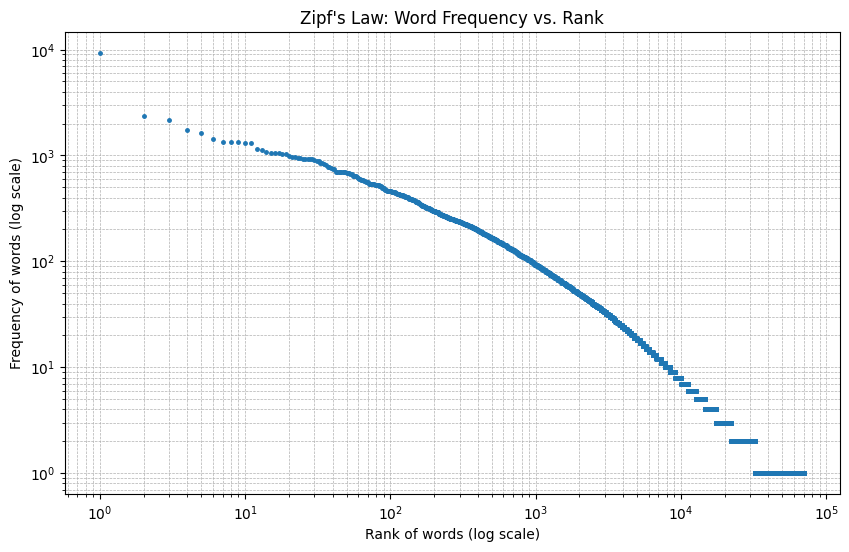

In [25]:
# Zipf's law for words in the corpus, excluding stopwords and words with fewer
# than 3 characters.
cnt_body = filtered_counter(all_words_body.term_total)
rank, frequency = create_zipfs_graph(cnt_body)

# test rank
assert rank[0] == 1
assert np.diff(rank).max() == 1
assert np.diff(rank).min() == 1
assert 70787 == len(rank)
# test frequency
assert 9266 == frequency[0]
assert all([d<=0 for d in np.diff(frequency)])
assert 52373 == sum(frequency[:40])
assert 38421 == sum([1 for f in frequency if f==1])
assert 10104 == sum([1 for f in frequency if f==2])

**Point to consider**: If we want to reduce index size, are we better off removing the few top words or the many infrequent words? What would be the implications for retrieval quality?

## Rare words

In addition to removing English stopwords and corpus stopwords, we would like to remove rare words. We will consider as rare all words with a fewer than three occurences in the body of articles in corpus (total word frequency of 2 or less).

**YOUR TASK (5 Points):** Complete the implementation of `get_rare_words` to return a list of corpus rare words.

In [26]:
def get_rare_words():
  """ Returns a list of corpus rare words, appearing fewer than three times in
      the body of articles in the corpus.
  """
  cnt_body = filtered_counter(all_words_body.term_total)

  # Filter words with frequency less than 3
  rare_words = [word for word, count in cnt_body.items() if count < 3]

  return rare_words

In [27]:
corpus_rarewords = get_rare_words()
assert len(corpus_rarewords) > 48000
assert 'yaron' in corpus_rarewords
assert 'year2020' in corpus_rarewords
assert 'uni' in corpus_rarewords
assert 'unforgivable' in corpus_rarewords
assert 'østfold' not in corpus_rarewords
assert 'new' not in corpus_rarewords

**Point to consider:** What are the pros and cons of keeping or removing rare words from the index?

# Index size

Great! Now that we've explored the words that make up our corpus we can proceed with index creation. We were asked to build three indices:

1. Excluding English and corpus stopwords.
2. Excluding English and corpus stopwords, and removing rare words.
3. Excluding English and corpus stopwords, removing rare words, and applying stemming.

To that end, we will use the `process_wiki` function defined earlier and provide it with three different tokenization functions that will yield the index we need. We also change our tokenization regex to exclude words shorter than 3 characters long.


## Creating indices

In [28]:
stop = frozenset(corpus_stopwords).union(english_stopwords)
stop_rare = stop.union(corpus_rarewords)

def tokenize_no_stop(text):
  return filter_tokens(tokenize(text), stop)
def tokenize_no_stop_rare(text):
  return filter_tokens(tokenize(text), stop_rare)
def tokenize_no_stop_stem(text):
  return filter_tokens(tokenize(text), stop_rare, True)
RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)

_, _, _ = process_wiki(pages, 'stop_removed', tokenize_no_stop)
_, _, _ = process_wiki(pages, 'stop_rare_removed', tokenize_no_stop_rare)
_, _, _ = process_wiki(pages, 'with_stemming', tokenize_no_stop_stem)

**Point to consider**: The above code iterates over the corpus three times. If we were to change the implementation of `process_wiki` so that it reads each document only once and adds its content to three indices, will the code execute three times faster?

## Calculating sizes

In order to examine the implications of our different word inclusion/exclusion criteria on index size, we will calculate the index size on disk in MB for each of the four indices we created in this assignment. For brevity, we will only look at the body indices and focus their posting files (ignoring the global dictionary statistics) since normally the posting files are much larger than the global dictionary / word statistics.

**YOUR TASK (10 Points):** Plot the indices size in a bar plot, where the X axis is the names of the indices and the Y axis is the size in MB. Make sure the indices are presented in a descending order based on the index size (from largest to smallest).  

In [29]:
def get_size(name):
  ''' Return the size in MB of the posting files of the body index named `name`.
  '''
  return sum(p.stat().st_size for p in Path('./body_indices').rglob(f'{name}*.bin'))/1000000

In [30]:
def plot_index_sizes(index_names):
  ''' Plot index size (MB) for each index given in `index_names`. Indices need
      to be presented in descending order, from largest (left) to smallest
      (right).
  Parameters:
  -----------
  index_names: list of str
    List of string index names, e.g. 'all_words'
  Returns:
  --------
  index_names: list of str
    List of string index names sorted in descending order of index sizes.
  sizes: list of int
    List of descending index sizes.
  '''
  # Calculate sizes for each index
  sizes = [get_size(name) for name in index_names]

    # Sort indices and sizes in descending order of size
  sorted_indices = sorted(zip(index_names, sizes), key=lambda x: x[1], reverse=True)
  index_names, sizes = zip(*sorted_indices)

    # Plot the bar chart
  plt.figure(figsize=(10, 6))
  plt.bar(index_names, sizes, color='skyblue')
  plt.title("Index Sizes (MB) in Descending Order", fontsize=14)
  plt.xlabel("Index Names", fontsize=12)
  plt.ylabel("Size (MB)", fontsize=12)
  plt.xticks(rotation=45, fontsize=10)
  plt.grid(axis='y', linestyle='--', linewidth=0.5)
  plt.tight_layout()
  plt.show()

  return list(index_names), list(sizes)

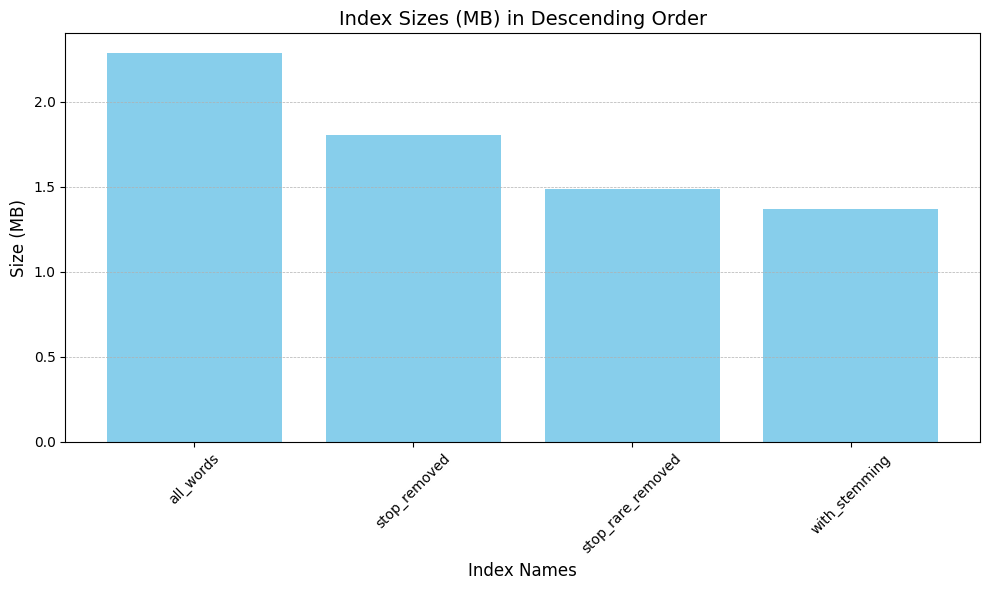

In [31]:
index_names, sizes = plot_index_sizes(
  ["stop_removed", "stop_rare_removed", "with_stemming", "all_words"]
)
assert all([s>0 for s in sizes])
assert all([d<0 for d in np.diff(sizes)])
assert list(map(_hash, index_names)) == \
  ['1b30d25775', '1ed1e86d00', 'dbdc047638', 'fb4af71be4']

**Points to consider:**

*   Can you explain the difference in index sizes?
*   Which of the indices is the smallest and why?
*   What is giving us more savings in terms of index size, removing high-frequency words or low-frequency words?
*   When processing the entire English Wikipedia (and not just 2000 articles as we did here), do you expect the removal of rare words to have a greater effect on index size?
*   Should we use stemming going forward?





